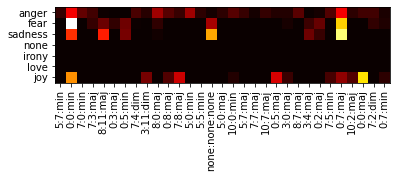

{'5:7:min': 0, '0:0:min': 1, '7:0:min': 2, '7:3:maj': 3, '8:11:maj': 4, '0:3:maj': 5, '0:5:min': 6, '7:4:dim': 7, '3:11:dim': 8, '8:0:maj': 9, '0:8:maj': 10, '7:8:maj': 11, '5:0:min': 12, '5:5:min': 13, 'none:none:none': 14, '5:0:maj': 15, '10:0:min': 16, '5:7:maj': 17, '7:7:maj': 18, '10:7:maj': 19, '0:5:maj': 20, '3:0:maj': 21, '8:7:maj': 22, '3:4:maj': 23, '0:2:maj': 24, '7:5:min': 25, '0:7:maj': 26, '10:2:maj': 27, '0:0:maj': 28, '7:2:dim': 29, '0:7:min': 30, 'START': -1, 'PAD': -2}
{'anger': 0, 'fear': 1, 'sadness': 2, 'none': 3, 'irony': 4, 'love': 5, 'joy': 6}


In [2]:
"""
BASED ON https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb
"""

import numpy as np
from numpy.random import uniform, multivariate_normal, dirichlet, random, randint
from numpy.linalg import norm

from gatherMatrices import getMixtureEmissionMatrices
from data.by_emotion_sample import extractEmotionTimeSeries, addRomanNumerals, addAlpha, addPseudoRomanNumeral
import pickle

np.set_printoptions(linewidth=100000)

songNumber = 2

df = extractEmotionTimeSeries(songNumber=songNumber, toDistribution=True)
df = addRomanNumerals(df, songNum=songNumber)
df = addAlpha(df, songNum=songNumber)
df = addPseudoRomanNumeral(df)

emissionMatrix, VtoI, ItoV, EtoI = getMixtureEmissionMatrices(df, plot=True)
print(VtoI)
print(EtoI)

In [3]:
def create_uniform_particles(
        a_range, f_range, s_range,
        n_range, i_range,
        l_range, j_range,
        N
):
    particles = np.empty((N, 7))
    for i, (var, range) in enumerate(locals().items()):
        if var[-5:] != "range": break
        particles[:, i] = uniform(range[0], range[1], size=N)
    # for i, row in enumerate(particles):
    #     particles[i, :] = row / sum(row)

    return particles

In [4]:
def predict(particles, phi, constant, epsilon_var, max_alpha=10):
    """
    Move alpha forward one time step according to alpha_t = phi * alpha_t-1 + epsilon
    Note: this operation is in-place
    """
    for i, alpha_t_1 in enumerate(particles):
        while True:
            epsilon = multivariate_normal(
                mean=[0 for _ in range(len(alpha_t_1))],
                cov=np.eye(len(alpha_t_1)) * epsilon_var
            )
            alpha_t = np.matmul(phi, alpha_t_1.T).squeeze() + epsilon + constant
            # print(alpha_t)
            # break
            if np.all(alpha_t > 0) and np.all(alpha_t < max_alpha):
                break

        particles[i, :] = alpha_t


In [5]:
def estimateParticleWeight(alpha: np.array, harmony: int, N=300) -> float:
    """
    Approximate the weight of a given particle associated with a given harmony
    :param alpha: the alpha value associated with the particle
    :param harmony: the observed harmony
    :param N: number of emission particles used to estimate the transition particle weights
    :return: Estimated weight of the given particle
    """
    samples = []
    for _ in range(N):
        p = dirichlet(alpha)
        h_dist = np.matmul(p, emissionMatrix).squeeze()
        h_dist = h_dist / norm(h_dist, ord=1)
        samples.append(h_dist[harmony]) #TODO: check that harmony index is same throughout
    return sum(samples) / len(samples)


def update(particles, harmony, weights, num_emission_particles=300):
    for i, particle in enumerate(particles):
        weights[i] *= estimateParticleWeight(particle, harmony, num_emission_particles)
    weights += 1e-300
    weights /= sum(weights)

In [6]:
def estimate(particles, weights):
    mean = np.average(particles, weights=weights, axis=0)
    var = np.average((particles - mean) ** 2, weights=weights, axis=0)
    # mean = mean / sum(mean)
    return mean, var

In [7]:
def resample(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill(1.0 / len(weights))

In [8]:
def effective_N(weights):
    return 1.0 / np.sum(np.square(weights))

In [9]:
from filterpy.monte_carlo import systematic_resample
from numpy.random import randn
import scipy.stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def filter_loop(
        particles,
        phi,
        constant,
        epsilon_var,
        max_alpha,
        harmony,
        num_emission_particles,
        num_particles,
        weights
):
    predict(particles, phi, constant, epsilon_var, max_alpha)
    update(particles, harmony, weights, num_emission_particles)

    if effective_N(weights) < num_particles/2:
        indexes = systematic_resample(weights)
        resample(particles, weights, indexes)
        assert np.allclose(weights, 1/num_particles)

    mu, var = estimate(particles, weights)
    return mu, var

def run_filter(
        num_particles: int,
        harmonies: list[int],
        phi: np.array=np.eye(7),
        constant: np.array=np.zeros((7,)),
        epsilon_var=0.1,
        max_alpha=10,
        num_emission_particles=300,
        plot=True,
        burn_in=10
):
    plt.figure()

    particles = create_uniform_particles(
        (0, max_alpha), (0, max_alpha), (0, max_alpha), (0, max_alpha),
        (0, max_alpha), (0, max_alpha), (0, max_alpha),
        num_particles
    )
    weights = np.ones(num_particles) / num_particles

    estimates = []
    for _ in (pbar := tqdm(range(burn_in), total=burn_in)):
        pbar.set_description(f"Burn in for {burn_in} steps")
        filter_loop(particles, phi, constant, epsilon_var, max_alpha, harmonies[0], num_emission_particles, num_particles, weights)
    for i, harmony in (pbar := tqdm(enumerate(harmonies), total=len(harmonies))):
        pbar.set_description(f"Running filter")
        mu, var = filter_loop(particles, phi, constant, epsilon_var, max_alpha, harmony, num_emission_particles, num_particles, weights)
        estimates.append(mu)

    estimates = np.array(estimates)
    print(estimates)
    if plot:
        plt.subplot(2, 1, 1)
        plt.stackplot(
            range(len(harmonies)),
            estimates[:, 0], estimates[:, 1], estimates[:, 2],
            estimates[:, 3], estimates[:, 4], estimates[:, 5], estimates[:, 6]
        )
        plt.subplot(2, 1, 2)
        for col in estimates.T:
            plt.plot(range(len(harmonies)), col, ls=(0, (1, 2)))
        plt.show()



In [10]:
from statsmodels.tsa.api import VAR
import pandas as pd
from timeSeries import loadAlphas, myVAR

In [19]:
alphas: pd.DataFrame = loadAlphas(32, 3)
alphas: pd.DataFrame = alphas.drop(columns=["index"])
phi, constant = myVAR(alphas, set_lag_num=1)
# phi /= np.amax(np.abs(phi)) + 1
phi = phi.round(3)
# constant /= np.amax(np.abs(constant)) + 1
constant = constant.round(3)
print(phi)
print(constant)

[[ 9.360e-01  3.000e-02  2.400e-02  3.700e-02  5.400e-02  5.160e-01  4.200e-02]
 [-2.800e-02  9.170e-01  1.500e-02  7.000e-03  3.100e-02  2.810e-01  2.800e-02]
 [-1.470e-01 -9.000e-03  7.730e-01 -1.800e-02 -1.600e-02 -1.380e-01  6.000e-03]
 [ 1.016e+00 -8.300e-02  2.420e-01  9.290e-01  2.500e-02 -2.460e-01  1.750e-01]
 [ 3.490e-01  6.760e-01  4.720e-01 -1.720e-01  3.680e-01 -4.796e+00 -1.075e+00]
 [-8.900e-02 -1.000e-03 -7.100e-02  9.000e-03  3.500e-02  1.245e+00  3.800e-02]
 [-1.100e-01 -1.110e-01 -1.890e-01 -2.200e-02 -1.000e-02 -1.370e-01  1.001e+00]]
[-0.234 -0.136 -0.034  0.072  0.154  1.291  0.253]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[[1.31307526 1.48798036 1.37986269 4.15457298 3.48098172 4.71545918 8.13255068]
 [1.24972232 1.44095057 1.36055784 4.11849925 3.37033052 4.62923829 8.19966248]
 [1.19016447 1.3763857  1.32314092 4.0799441  3.27956941 4.58501112 8.27459788]
 [1.17850005 1.31430333 1.28773232 4.06774438 3.20785113 4.54327481 8.34055188]
 [1.16992049 1.2758889  1.26077112 4.05691347 3.14499919 4.55844488 8.41296682]
 [1.14876545 1.22561234 1.2237411  4.06916164 3.08019472 4.52828799 8.4456717 ]
 [1.10694522 1.20058426 1.15888497 4.08828362 2.96868587 4.50680736 8.49523307]
 [1.064217   1.20395438 1.13221818 4.08296428 2.86749403 4.50234492 8.56922613]
 [1.03403661 1.17462221 1.09147845 4.0742689  2.77119139 4.5186512  8.63246056]
 [1.01216829 1.15778833 1.05986099 4.04734679 2.70832821 4.53720323 8.67890925]
 [1.00829477 1.12097489 1.02932951 4.03594752 2.6722906  4.55877749 8.7206008 ]
 [1.00839651 1.11328979 1.02444673 4.07429151 2.63835968 4.58369516 8.68915598]
 [1.04728638 1.07730224 1.02170438 4.014

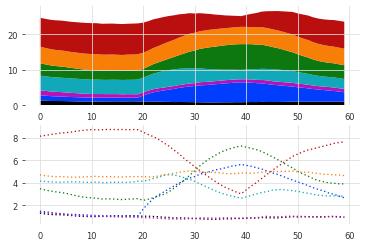

In [21]:
# phi = np.array([
#     [1, 0, 0, 0, 0, 0, 0],
#     [0, 1, 0, 0, 0, 0, 0],
#     [0, 0, 1, 0, 0, 0, 0],
#     [0, 0, 0, 1, 0, 0, 0],
#     [0, 0, 0, 0, 1, 0, 0],
#     [0, 0, 0, 0, 0, 1, 0],
#     [0, 0, 0, 0, 0, 0, 1]
# ])
phi = np.eye(7)
constant = np.zeros((7,))
harmonies = [VtoI["0:0:maj"] for _ in range(20)] + [VtoI["0:3:maj"] for _ in range(20)] + [VtoI["0:0:maj"] for _ in range(20)]
run_filter(
    num_particles=300,
    harmonies=harmonies,
    phi=phi, constant=constant, epsilon_var=0.1,
    max_alpha=10,
    num_emission_particles=300,
    burn_in=10
)

In [ ]:
particles = create_uniform_particles(
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    4
)
print(particles)
predict(particles, np.eye(7), 0.01)
weights = np.array([1/len(particles) for _ in range(len(particles))])
print(particles)
update(particles, 3, weights)
print(weights)
mean, var = estimate(particles, weights)
print(mean)